In [1]:
# https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling
# https://pypi.org/project/ChannelAttribution/

In [2]:
# !pip install --upgrade pip
# !pip install ChannelAttribution

In [3]:
%%capture

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.express as px
import plotly.graph_objects as go
from ChannelAttribution import *
import plotly.io as pio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

# Set the random seed for reproducibility
np.random.seed(41)

# Generate dummy data
n_rows = 250000
n_cookies = 100000
cookies = [f'{i:024x}' for i in np.random.randint(1, 1 << 48, n_cookies)]

# Define channels
# channels = ['Instagram', 'Online Display', 'Google Paid Search', 'Bing Paid Search', 'Email', 'Organic Search', 'Direct']
# channel_probs = [0.14, 0.19, 0.30, 0.07, 0.04, 0.08, 0.18]  # Uneven probabilities for channels

channels = [
    "Instagram",
    "Facebook",
    "Google Paid Search",
    "Bing Paid Search",
    "Twitter",
    "LinkedIn",
    "Pinterest",
    "Snapchat",
    "TikTok",
    "YouTube",
    "Online Display",
    "Email",
    "Organic Search",
    "Direct",
    "Affiliate Marketing",
    "Influencer Marketing",
    "Content Marketing",
    "SMS Marketing",
    "Podcast Advertising",
    "Referral Programs"
]
channel_probs = np.random.dirichlet(np.ones(20), size=1)[0]  # Generate random probabilities that sum to 1


# Generate data for each column
cookie_column = np.random.choice(cookies, n_rows)
channel_column = np.random.choice(channels, n_rows, p=channel_probs)
time_column = pd.to_datetime(np.random.randint(int(pd.Timestamp('2024-01-01').timestamp()), int(pd.Timestamp('2024-12-31').timestamp()), n_rows), unit='s')
conversions = np.random.choice([0, 1], n_rows, p=[0.9, 0.1])
conversion_values = conversions * np.round(np.random.uniform(10, 1000, n_rows), 2)


# Create DataFrame
data = {
    'cookie': cookie_column,
    'channel': channel_column,
    'time': time_column,
    'conversion': conversions,
    'conversion_value': conversion_values
}

df = pd.DataFrame(data)

# Sort by cookie and time
df = df.sort_values(by=['cookie', 'time'])

# Modify 'interaction' column to be either 'impression' or 'conversion'
df['interaction'] = df['conversion'].apply(lambda x: 'conversion' if x == 1 else 'impression')

# Show the first few rows
print(df.head())

# Save to a CSV file
df.to_csv('dummy_data.csv', index=False)

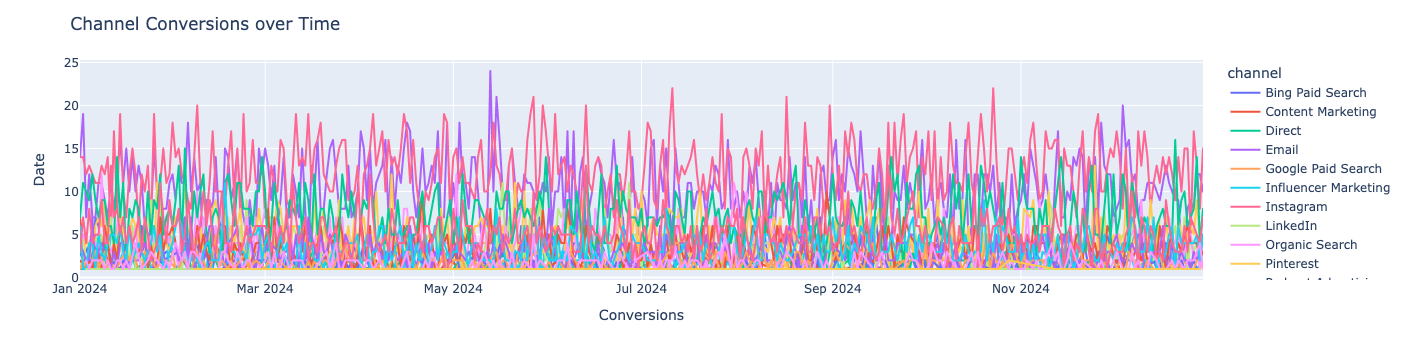

In [4]:
#Plotting conversions over time by channel
conversions = df.loc[df['conversion'] == 1]
conversions['time'] = conversions['time'].dt.date
conversions = conversions[conversions['time']< pd.to_datetime("2024-12-31").date()]
conversions.drop(columns = ['cookie', 'interaction'], inplace = True)
conversions = conversions.groupby(['time','channel'], as_index=False).sum()

fig = px.line(conversions, x='time', y='conversion', color='channel')

fig.update_layout(title='Channel Conversions over Time',
                   xaxis_title='Conversions',
                   yaxis_title='Date')
fig.show()

In [19]:
#Creating the path order for when users interact with different channels (this is equivalent to SQL window functions)
df['path_order'] = df.sort_values(['time']).groupby(['cookie']).cumcount() + 1
df.to_csv('ordered_data.csv', index=False)
df.head()

cookie         channel                time  \
122368  000000000000000093179b98  Organic Search 2024-05-09 05:47:24   
222536  000000000000000093179b98   SMS Marketing 2024-05-25 21:24:35   
5095    000000000000000093179b98       Pinterest 2024-06-15 14:58:23   
138191  000000000000000093179b98         Twitter 2024-11-16 07:39:55   
31148   0000000000000000ed9519c4       Pinterest 2024-03-14 07:41:46   

        conversion  conversion_value interaction  path_order  
122368           0               0.0  impression           1  
222536           0               0.0  impression           2  
5095             0               0.0  impression           3  
138191           0               0.0  impression           4  
31148            0               0.0  impression           1

In [6]:
#Aggregating the channels a user interacted with into a single row
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"channel": "path"})
df_paths.head()

cookie                                               path
0  000000000000000093179b98  [Organic Search, SMS Marketing, Pinterest, Twi...
1  0000000000000000ed9519c4  [Pinterest, Email, YouTube, Podcast Advertisin...
2  00000000000000011a43ad3f                      [YouTube, Pinterest, YouTube]
3  000000000000000135b879b0              [Instagram, Instagram, SMS Marketing]
4  000000000000000413065086                                     [Email, Email]

In [7]:
#Looking at the last interaction to see if it led to a user converting
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]
df_last_interaction.head()

cookie  conversion  conversion_value
138191  000000000000000093179b98           0               0.0
21435   0000000000000000ed9519c4           0               0.0
85173   00000000000000011a43ad3f           0               0.0
115613  000000000000000135b879b0           0               0.0
225327  000000000000000413065086           0               0.0

In [8]:
#Concatinating with the dataframes of user path's
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

cookie  \
0  000000000000000093179b98   
1  0000000000000000ed9519c4   
2  00000000000000011a43ad3f   
3  000000000000000135b879b0   
4  000000000000000413065086   

                                                path  conversion  \
0  [Organic Search, SMS Marketing, Pinterest, Twi...           0   
1  [Pinterest, Email, YouTube, Podcast Advertisin...           0   
2                      [YouTube, Pinterest, YouTube]           0   
3              [Instagram, Instagram, SMS Marketing]           0   
4                                     [Email, Email]           0   

   conversion_value  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [9]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Total conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total value of conversions: ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))

Total conversions: 24771
Total conversion rate: 10%
Total value of conversions: $12521510
Average conversion value: $505


In [10]:
#We will create a variable ‘path’ in the specific formatrequired by the Attribution Model where the ordered channels a user interacts with are delimited by'>'
def listToString(df):  
    str1 = ""  
    for i in df['path']:  
        str1 += i + ' > '    
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()

cookie  \
0  000000000000000093179b98   
1  0000000000000000ed9519c4   
2  00000000000000011a43ad3f   
3  000000000000000135b879b0   
4  000000000000000413065086   

                                                path  conversion  \
0  Organic Search > SMS Marketing > Pinterest > T...           0   
1  Pinterest > Email > YouTube > Podcast Advertis...           0   
2                      YouTube > Pinterest > YouTube           0   
3              Instagram > Instagram > SMS Marketing           0   
4                                      Email > Email           0   

   conversion_value  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [11]:
#Removing the user's cookie and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
df_paths.drop(columns = 'cookie', inplace = True)
df_paths['null'] = np.where(df_paths['conversion'] == 0,1,0)

attribution_df = df_paths.groupby(['path'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "conversion_value": "total_conversion_value"}, inplace = True)
attribution_df.sample(10)

path  total_conversions  \
7678   Instagram > Instagram > Organic Search > Email...                  0   
15895  Podcast Advertising > YouTube > YouTube > Pint...                  0   
7395   Instagram > Influencer Marketing > YouTube > T...                  0   
2916   Email > Instagram > Instagram > YouTube > Bing...                  0   
17189  Referral Programs > YouTube > Organic Search >...                  0   
9941    Instagram > YouTube > Instagram > Organic Search                  0   
21112  TikTok > Referral Programs > Referral Programs...                  1   
7830   Instagram > Instagram > SMS Marketing > Snapch...                  0   
14011  Pinterest > Email > Pinterest > Referral Progr...                  0   
14365  Pinterest > Instagram > Referral Programs > Tw...                  0   

       total_conversion_value  total_null  
7678                     0.00           1  
15895                    0.00           1  
7395                     0.00           1  
2916                     0.00           1  
17189                    0.00           1  
9941                     0.00           3  
21112                  481.06           0  
7830                     0.00           1  
14011                    0.00           1  
14365                    0.00           1

In [12]:
#Now, we will use the ChannelAttribution package to create the attribution models described above

#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")

#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 2.16% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (12) is reached: 99.75%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


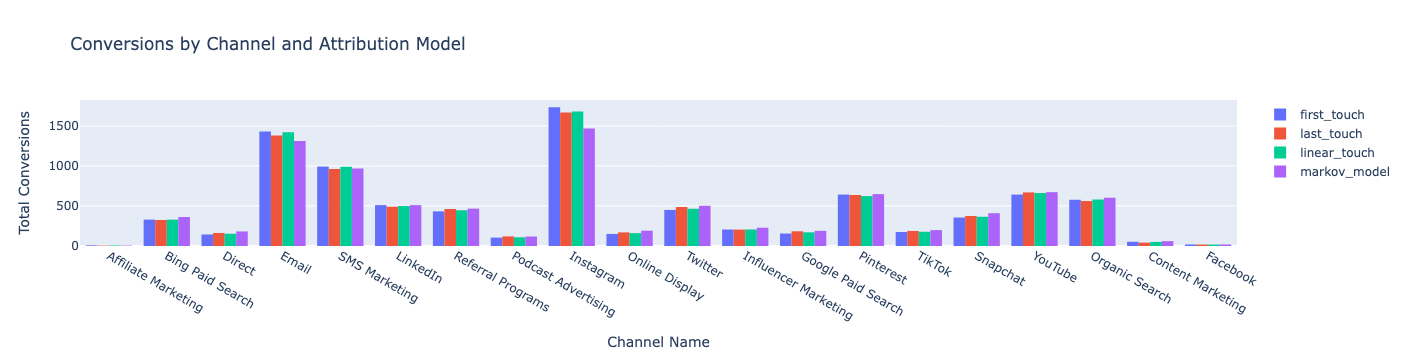

In [13]:
# Merge dataframes H and M
R = pd.merge(H, M, on="channel_name", how="inner")

# Select and rename columns
R1 = R[["channel_name", "first_touch_conversions", "last_touch_conversions",
        "linear_touch_conversions", "total_conversions"]]
R1.columns = ["channel_name", "first_touch", "last_touch", "linear_touch", "markov_model"]

# Melt the dataframe
R1 = pd.melt(R1, id_vars="channel_name")

# Create the histogram
fig = go.Figure()

# Add traces for each conversion type
for conversion_type in R1['variable'].unique():
    df_filtered = R1[R1['variable'] == conversion_type]
    fig.add_trace(go.Histogram(
        x=df_filtered['channel_name'],
        y=df_filtered['value'],
        name=conversion_type,
        histfunc='sum'
    ))

# Update layout
fig.update_layout(
    title='Conversions by Channel and Attribution Model',
    xaxis_title='Channel Name',
    yaxis_title='Total Conversions',
    barmode='group'
)

# Show the figure
fig.show()

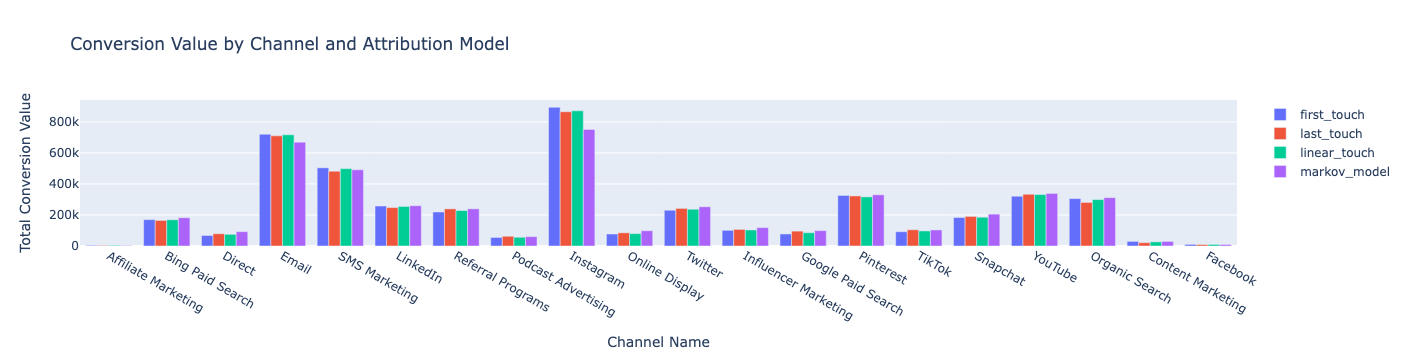

In [14]:
# Select and rename columns
R2 = R[["channel_name", "first_touch_value", "last_touch_value",
        "linear_touch_value", "total_conversion_value"]]
R2.columns = ["channel_name", "first_touch", "last_touch", "linear_touch", "markov_model"]

# Melt the dataframe
R2 = pd.melt(R2, id_vars="channel_name")

# Create the barchart
fig = go.Figure()

# Add traces for each conversion value type
for value_type in R2['variable'].unique():
    df_filtered = R2[R2['variable'] == value_type]
    fig.add_trace(go.Bar(
        x=df_filtered['channel_name'],
        y=df_filtered['value'],
        name=value_type
    ))

# Update layout
fig.update_layout(
    title='Conversion Value by Channel and Attribution Model',
    xaxis_title='Channel Name',
    yaxis_title='Total Conversion Value',
    barmode='group'  # Set to 'group' to display bars next to each other
)

# Show the figure
fig.show()

In [15]:
R = R.rename(columns={'total_conversions':'markov_model_conversions', 'total_conversion_value':'markov_model_value'})
R['M_LT_Change'] = R['markov_model_conversions'] / R['last_touch_conversions'] - 1
R = R.round(2)

R.to_csv('dda_output.csv', index=False)
R[:]

channel_name  first_touch_conversions  first_touch_value  \
0    Affiliate Marketing                      8.0            3997.33   
1       Bing Paid Search                    330.0          169915.06   
2                 Direct                    144.0           67875.01   
3                  Email                   1433.0          720554.94   
4          SMS Marketing                    993.0          504167.24   
5               LinkedIn                    511.0          257935.14   
6      Referral Programs                    433.0          219419.94   
7    Podcast Advertising                    105.0           55279.55   
8              Instagram                   1734.0          894323.37   
9         Online Display                    151.0           77275.94   
10               Twitter                    451.0          230518.84   
11  Influencer Marketing                    206.0          101095.31   
12    Google Paid Search                    156.0           77652.68   
13             Pinterest                    643.0          326166.88   
14                TikTok                    175.0           92104.14   
15              Snapchat                    356.0          183626.85   
16               YouTube                    643.0          320753.81   
17        Organic Search                    578.0          305556.07   
18     Content Marketing                     53.0           29753.21   
19              Facebook                     19.0           10334.09   

    last_touch_conversions  last_touch_value  linear_touch_conversions  \
0                      5.0           3303.30                      6.71   
1                    325.0         164807.34                    329.51   
2                    163.0          79024.54                    153.47   
3                   1382.0         710158.80                   1420.54   
4                    964.0         482203.15                    990.58   
5                    491.0         247678.63                    499.67   
6                    463.0         239397.00                    446.70   
7                    120.0          62788.45                    108.75   
8                   1669.0         865614.17                   1681.78   
9                    170.0          85068.86                    161.02   
10                   488.0         242309.79                    465.81   
11                   205.0         107005.20                    206.58   
12                   184.0          95947.31                    170.55   
13                   638.0         322698.70                    624.12   
14                   188.0         104617.95                    178.09   
15                   375.0         190805.35                    365.77   
16                   670.0         333616.43                    662.16   
17                   562.0         280809.53                    581.28   
18                    42.0          21492.06                     50.99   
19                    18.0           8958.84                     17.91   

    linear_touch_value  markov_model_conversions  markov_model_value  \
0              3931.91                      5.52             3220.75   
1            169106.74                    362.91           182269.69   
2             75295.96                    182.05            92413.74   
3            717031.20                   1311.76           669681.09   
4            498670.43                    969.34           491362.76   
5            254826.72                    510.67           259706.82   
6            228483.56                    467.33           239592.77   
7             56249.45                    118.21            60338.67   
8            871526.96                   1468.58           751796.72   
9             79907.83                    191.11            98386.08   
10           236997.78                    502.79           252943.55   
11           103301.15                    228.54           118598.81   
12      

In [16]:
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


In [17]:
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)
matrix.rename(columns={'(null)':'No Conv'}, inplace=True)

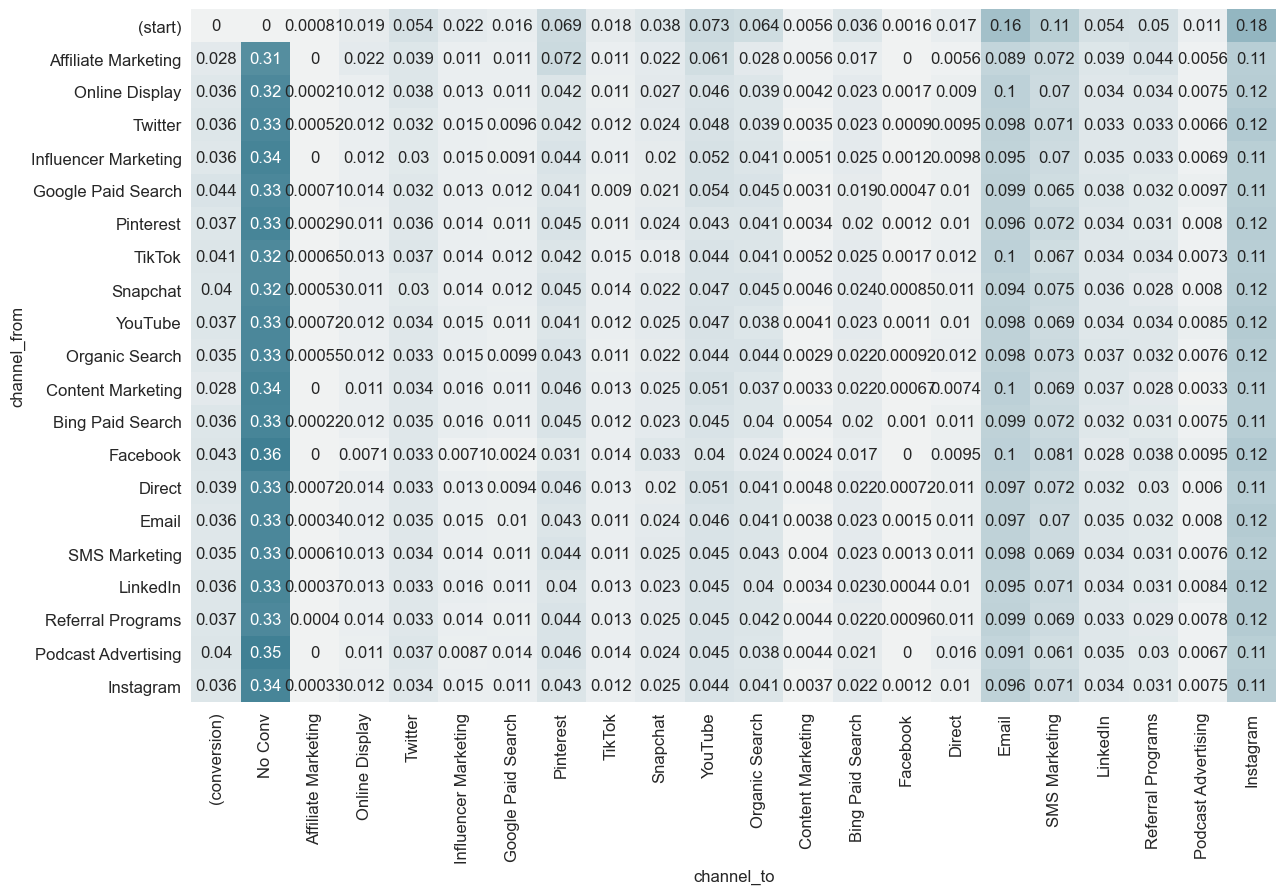

In [18]:
#Heat map for transition probabilities in the data set
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)

fig.savefig('heatmap_output.png')